In [1]:
#import packages
import pandas as pd
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
from cmdstanpy import CmdStanMCMC

/opt/anaconda3/envs/stan_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#modify import path
import sys
sys.path.append('../our_analysis')

#import our code
from logreg import run_logistic_regression
from simple_logreg import run_logistic_regression, compare_conditions

In [3]:
#Set WD
notebook_dir = os.getcwd()

In [ ]:
#load dataset
df = pd.read_csv("../dataset/beh_noslow.csv") # need to change this later
# df = pd.read_csv("../dataset/all_subjects.csv") # need to change this later

story_trials = df[df["condition"] == "story"]
abstract_trials=df[df["condition"] == "abstract"]

## need to do some data cleaning as they have nans

below we are plotting only the raw probabilities. I need to modify this to plot the logit based predicted probabilities. Also need to double check how the transition stay/leave is calculated

In [ ]:
story_results = run_logistic_regression(
    df=story_trials,
    condition_name='story',
    output_dir='story_logreg_results'
)

abstract_results = run_logistic_regression(
    df=abstract_trials,
    condition_name='abstract',
    output_dir='abstract_logreg_results'
)



In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import sem

def plot_stay_probability(story_results, abstract_results, save_figs=False):
   
    _, _, story_coef_df = story_results
    _, _, abstract_coef_df = abstract_results
    
    for condition_name, coef_df in [("story", story_coef_df), ("abstract", abstract_coef_df)]:
        if coef_df is None or len(coef_df) == 0:
            print(f"No valid results for {condition_name}")
            continue
            
        conds = {
            "Rewarded-Common":   (1, 1),
            "Rewarded-Rare":     (1, -1),
            "Unrewarded-Common": (-1, 1),
            "Unrewarded-Rare":   (-1, -1),
        }
        
        participant_probs = {name: [] for name in conds}
        
        for pid in coef_df.index:
            # Extract coefficients for each participant
            b0 = coef_df.loc[pid, 'Intercept']
            br = coef_df.loc[pid, 'Reward']
            bt = coef_df.loc[pid, 'Common']
            bir = coef_df.loc[pid, 'Reward*Common']
            
            for name, (xr, xt) in conds.items():
                lin = b0 + br*xr + bt*xt + bir*(xr*xt)
                p = 1 / (1 + np.exp(-lin))
                p = np.clip(p, 0.001, 0.999)
                
                participant_probs[name].append(p)
        
        groups = ["Rewarded", "Unrewarded"]
        common_vals = [participant_probs[f"{g}-Common"] for g in groups]
        rare_vals = [participant_probs[f"{g}-Rare"] for g in groups]
        
#       Group stats
        common_means = [np.mean(vals) for vals in common_vals]
        rare_means = [np.mean(vals) for vals in rare_vals]
        
        common_se = [sem(vals) * 1.96 for vals in common_vals]  # 95% CI using normal approximation
        rare_se = [sem(vals) * 1.96 for vals in rare_vals]
        
        x = np.arange(len(groups))
        width = 0.35
        
        plt.rcParams.update({'font.family': 'Arial', 'font.size': 12})
        fig, ax = plt.subplots(figsize=(8, 5), facecolor='white')
        
        #Common
        common_bar = ax.bar(
            x - width/2,
            common_means,
            width,
            yerr=common_se,
            capsize=5,
            color="#7EA6E0",     
            edgecolor="#7EA6E0", 
            label="Common",
            alpha=0.9,
        )
        #Rare
        rare_bar = ax.bar(
            x + width/2,
            rare_means,
            width,
            yerr=rare_se,
            capsize=5,
            color="#E07E7E",     
            edgecolor="#E07E7E",
            label="Rare",
            alpha=0.9,
        )
        
        # inds dots
        dot_color = "#50C878"  
        for i, g in enumerate(groups):
            # Common dots
            jitter = (np.random.rand(len(common_vals[i])) - 0.5) * width * 0.4
            ax.scatter(
                np.full(len(common_vals[i]), x[i] - width/2) + jitter,
                common_vals[i],
                color=dot_color,
                alpha=0.7,
                s=25,
                edgecolor='white',
                linewidth=0.5
            )
            
            # Rare dots
            jitter = (np.random.rand(len(rare_vals[i])) - 0.5) * width * 0.4
            ax.scatter(
                np.full(len(rare_vals[i]), x[i] + width/2) + jitter,
                rare_vals[i],
                color=dot_color,
                alpha=0.7,
                s=25,
                edgecolor='white',
                linewidth=0.5
            )
        
        ax.set_xticks(x)
        ax.set_xticklabels(groups, fontsize=13, fontweight='bold')
        ax.set_ylabel("Predicted Stay Probability", fontsize=13, fontweight='bold')
        ax.set_title(f"Stay Probability by Reward & Transition | {condition_name.capitalize()}", fontsize=15, fontweight='bold')
        ax.legend(title="Transition Type", fontsize=11, title_fontsize=12)
        
        ax.yaxis.grid(True, linestyle='--', alpha=0.7, color='#CCCCCC')
        ax.set_axisbelow(True)
        ax.set_ylim(0, 1)  # Probability is between 0 and 1
        
        for spine in ax.spines.values():
            spine.set_linewidth(1.2)
            spine.set_color('#2C3E50')
        
        plt.tight_layout()
        
        print(f"\nCondition: {condition_name}")
        print(f"Number of participants: {len(coef_df)}")
        for i, group in enumerate(groups):
            print(f"{group}-Common: {common_means[i]:.3f} ± {common_se[i]:.3f}")
            print(f"{group}-Rare: {rare_means[i]:.3f} ± {rare_se[i]:.3f}")
        
        if save_figs:
            plt.savefig(f"{condition_name}_stay_probability.png", dpi=300, bbox_inches="tight")
        
        plt.show()




Condition: story
Number of participants: 46
Rewarded-Common: 0.814 ± 0.059
Rewarded-Rare: 0.482 ± 0.080
Unrewarded-Common: 0.499 ± 0.050
Unrewarded-Rare: 0.781 ± 0.054


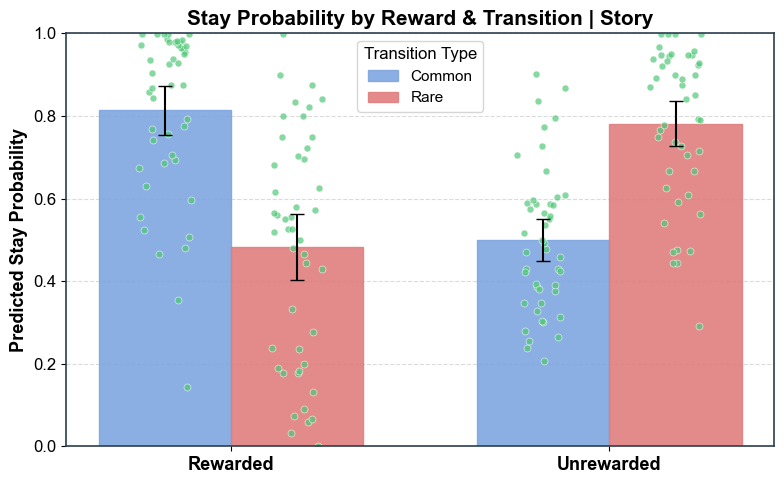


Condition: abstract
Number of participants: 48
Rewarded-Common: 0.868 ± 0.040
Rewarded-Rare: 0.747 ± 0.042
Unrewarded-Common: 0.663 ± 0.046
Unrewarded-Rare: 0.786 ± 0.047


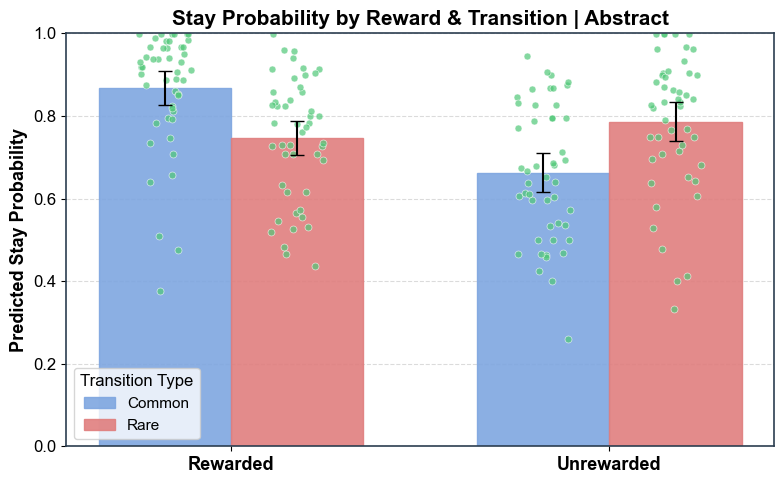

In [9]:
plot_stay_probability(story_results, abstract_results, save_figs=False)